In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from copy import deepcopy


In [10]:
# 数据准备
data = pd.read_csv("featureimportance.csv")
X = data[['N', 'SBET', 'Vmicro']].values.astype(np.float32)
y = data['CO2uptake'].values.reshape(-1, 1).astype(np.float32)

# 数据标准化
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

In [11]:
# 数据集划分 (80%训练, 20%测试)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# 转换为PyTorch张量
train_dataset = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.FloatTensor(y_train))
test_dataset = TensorDataset(
    torch.FloatTensor(X_test), 
    torch.FloatTensor(y_test))


In [12]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[128, 17], dropout=0.1):
        super(SimpleMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
            
        self.features = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, 1)
        
    def forward(self, x):
        x = self.features(x)
        return self.output(x)

In [13]:
# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params_dict = {
    'lr': 0.007874797870587109,
    'batch_size': 16
}

final_model = SimpleMLP().to(device)
# 直接加载预训练模型
final_model.load_state_dict(torch.load('best_mlp_model.pth'))
final_model.eval()  # 切换到评估模式

# 准备数据加载器
test_loader = DataLoader(test_dataset, batch_size=params_dict['batch_size'], shuffle=False)

# 仅进行模型评估
criterion = nn.MSELoss()
val_loss = 0
predictions = []
true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        
        # 收集预测结果用于可视化
        predictions.extend(outputs.cpu().numpy())
        true_values.extend(targets.cpu().numpy())
        
        val_loss += criterion(outputs, targets).item()

val_loss /= len(test_loader)
print(f"Final Validation Loss: {val_loss:.4f}")

Final Validation Loss: 0.8732


C:\Users\徐鹏宇\AppData\Local\Temp\ipykernel_19780\729340402.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_mlp_model.pth'))


Calculating SHAP values for training set...


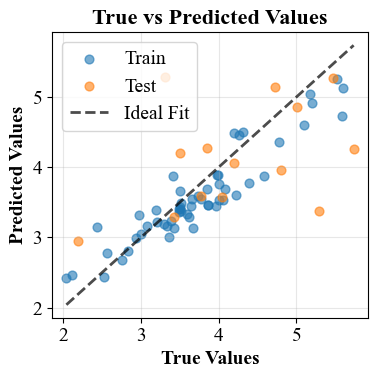

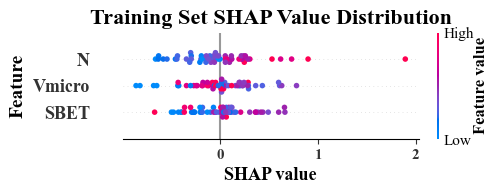

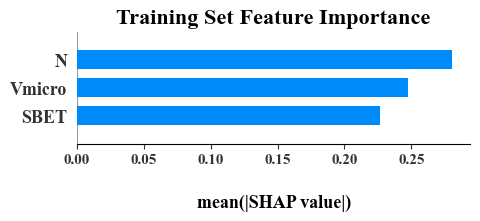

In [14]:
def comprehensive_shap_analysis(model, X_train, X_test, y_train, y_test, feature_names=None, device='cpu', max_samples=1000):
    try:
        # 设置全局字体和样式
        plt.rcParams.update({
            'font.family': 'Times New Roman',
            'font.size': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'axes.labelweight': 'bold',
            'figure.autolayout': True  # 自动调整布局
        })
        
        # 数据准备
        if isinstance(X_train, torch.Tensor):
            X_train = X_train.cpu().numpy()
            y_train = y_train.cpu().numpy()
        if isinstance(X_test, torch.Tensor):
            X_test = X_test.cpu().numpy()
            y_test = y_test.cpu().numpy()
            
        # 随机子采样（如果数据量太大）
        if len(X_train) > max_samples:
            idx = np.random.choice(len(X_train), max_samples, replace=False)
            X_train, y_train = X_train[idx], y_train[idx]
            
        # 转换为tensor并获取预测值
        background = torch.FloatTensor(X_train).to(device)
        test_data = torch.FloatTensor(X_test).to(device)
        
        train_pred = model(background).detach().cpu().numpy().flatten()
        test_pred = model(test_data).detach().cpu().numpy().flatten()

        # 创建解释器并计算训练集SHAP值
        explainer = shap.DeepExplainer(model, background)
        print("Calculating SHAP values for training set...")
        train_shap = explainer.shap_values(background)
        
        # 统一SHAP值格式
        def _process_shap(shap_vals):
            if isinstance(shap_vals, list):
                return shap_vals[0]
            elif len(shap_vals.shape) == 3:
                return shap_vals[:,:,0]
            return shap_vals
            
        train_shap = _process_shap(train_shap)

        # ========== 图表1: 预测值与真实值对比图 ==========
        plt.figure(figsize=(4, 4))
        
        # 绘制训练集数据（蓝色）
        plt.scatter(y_train, train_pred, 
                  alpha=0.6, color='#1f77b4', label='Train', s=40)
        
        # 绘制测试集数据（橙色）
        plt.scatter(y_test, test_pred,
                  alpha=0.6, color='#ff7f0e', label='Test', s=40)
        
        # 绘制理想拟合线
        min_val = min(np.min(y_train), np.min(y_test), np.min(train_pred), np.min(test_pred))
        max_val = max(np.max(y_train), np.max(y_test), np.max(train_pred), np.max(test_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 
                'k--', lw=2, alpha=0.7, label='Ideal Fit')
        
        plt.xlabel('True Values', fontweight='bold')
        plt.ylabel('Predicted Values', fontweight='bold')
        plt.title('True vs Predicted Values', fontweight='bold')
        plt.legend(loc='upper left')
        plt.grid(alpha=0.3)

        plt.savefig('true_vs_predicted.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()

        # ========== 图表2: 训练集SHAP值分布图 ==========
        plt.figure(figsize=(5, 2))
        shap.summary_plot(train_shap, X_train, 
                         feature_names=feature_names,
                         show=False,
                         plot_size=None)  # 禁用SHAP内部大小设置
        
        plt.title('Training Set SHAP Value Distribution', fontweight='bold')
        plt.xlabel('SHAP value', fontweight='bold')
        plt.ylabel('Feature', fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')

        plt.savefig('train_shap_distribution.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()

        # ========== 图表3: 训练集特征重要性图 ==========
        plt.figure(figsize=(5, 2))
        shap.summary_plot(train_shap, X_train,
                         feature_names=feature_names,
                         plot_type='bar',
                         show=False,
                         plot_size=None)
        ax = plt.gca()

# 手动设置 x 轴标题的位置
        ax.set_xlabel('mean(|SHAP value|)', labelpad=20, fontweight='bold')
        plt.title('Training Set Feature Importance', fontweight='bold')
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')

        plt.savefig('train_feature_importance.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()
        
        # ========== 返回训练集特征重要性分析结果 ==========
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(train_shap).mean(axis=0)
        }).sort_values('Importance', ascending=False)
        
        return importance_df
        
    except Exception as e:
        print(f"Error in SHAP analysis: {str(e)}")
        traceback.print_exc()
        return None

# 使用示例
importance_results = comprehensive_shap_analysis(
    final_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    feature_names=['N', 'SBET', 'Vmicro'],
    device=device
)
